In [1]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
First created on July 30 2018
@author: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. TESTING_FOLDER will be filled during the run with images from the analysis analysis

3. (OPTIONAL) Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes somewhat large and possiblhy hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/nevencaplar/Documents/PFS/'
############################################################
    
TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'

# create these directories if they do not exist
import os
for i in [PSF_DIRECTORY,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)    
    

In [2]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}


<IPython.core.display.Javascript object>

In [3]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 2

#import Zernike_Module
#from Zernike_Module import LNP_PFS,LN_PFS_single,create_parInit,downsample_manual_function,Zernike_Analysis,PFSPupilFactory,custom_fftconvolve,stepK,maxK,sky_scale,sky_size,create_x,remove_pupil_parameters_from_all_parameters

#Zernike_Module_lastOct15_beforeScatterChange
import Zernike_Module
from Zernike_Module import *

In [5]:
#general import statments
from __future__ import absolute_import, division, print_function
import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math
import pickle

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

# lmfit 
# import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 18})
%config InlineBackend.rc = {}
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

from shutil import copy
from scipy.optimize import curve_fit

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c

## Single example with dummy values to check that the code  is working

In [49]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  
"""
# zernike parameters that control the wavefront
@param z4                     defocus parameter 
@param z5-z11                 further Zernike coefficents describing the wavefront, following Noel convention

# first set of parameters describing the pupil
@param hscFrac                Value determining how much of the exit pupil obscured by the central obscuration(detector)  (name is relic of the code when it was used for Hyper Suprime cam project)
@param strutFrac              Value determining how much of the exit pupil is obscured by a single strut
@param dxFocal, dyFocal       Value determining the position of the central obscuration(detector) in the focal plane
@param slitFrac               Value determining how much of the exit pupil is obscured by slit 
@param slitFrac_dy            Value determining what is the vertical position of the slit in the exit pupil

# set of parameters change of illumination between the entrence pupil and the exit pupil
# June 04, 2019 - I am not sure if I need those!!!
@param radiometricEffect      parameter describing the change of the illumination (1-params['radiometricEffect']**2*r**2)**(params['radiometricExponent'])
@param radiometricExponent    parameter describing the change of the illumination (1-params['radiometricEffect']**2*r**2)**(params['radiometricExponent'])
@param x_ilum, y_ilum         positions of the centrer of the nonuniform illumination

# illumination due to fiber, parameters
@param x_fiber                position of the fiber misaligment in the x direction
@param y_fiber                position of the fiber misaligment in the y direction
@param effective_ilum_radius  fraction of the maximal radius of the illumination of the exit pupil   
@param frd_sigma              sigma of Gaussian convolving only outer edge, mimicking FRD
@param frd_lorentz_factor     strength of the lorentzian factor describing wings of the pupil illumination

# further pupil parameters (second set of parameters describing the pupil)
@param det_vert                  multiplicative factor determining vertical size of the detector obscuration
@param slitHolder_frac_dx        dx position of slit holder

# convolving (postprocessing) parameters
@param grating_lines             number of effective lines in the grating
@param scattering_slope          slope of scattering
@param scattering_amplitude      amplitude of scattering compared to optical PSF
@param pixel_effect              sigma describing charge diffusion effect [in units of 15 microns]
@param fiber_r                   radius of perfect tophat fiber, as seen on the detector [in units of 15 microns]         
@param flux                      total flux in generated image compared to input image (it will probably be 1 or very close to 1)
"""


sci_image_unit=np.ones((50,50))*10
var_image_unit=np.ones((50,50))*10

# same rows holds parameters of the same group, as described in the comment above
allparameters_proposal=np.array([0,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.7,0.1,0.3,0.0,0.07,0.0,
                                 0.17,0,1,1,
                                 0.0,-0.0,0.80,0.08,0.8,
                                 1.06,0.28,
                                 50000,2.5,0.027,0.37,1.85,1.0])
print('version of the code is: '+str(Zernike_Module.__version__))
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1)   

res=model(allparameters_proposal,return_Image=True)

# last value should be -1183627.3527894863
print('Likelihood is: '+str(res[0]))

version of the code is: 0.21c
extraZernike: None
zmax: 11
31
Likelihood is: -1185073.5390907654


# overview of the procedure 

## ilumination of the exit pupil

(3072, 3072)

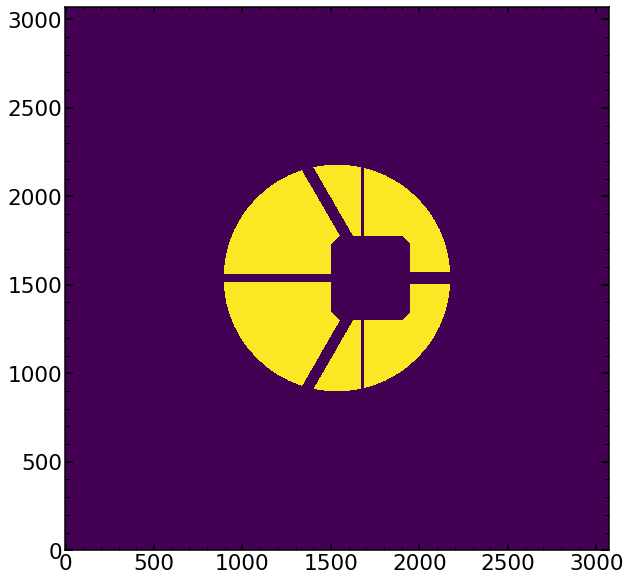

In [50]:
# this is the full pupil - just cutout of the pupil and all of the obstructions in - but without FRD

plt.figure(figsize=(10,10))
aperilluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'aperilluminated.npy') 
plt.imshow(aperilluminated,origin='lower')
aperilluminated.shape

Text(0.5,1,'1d plot of the illumination')

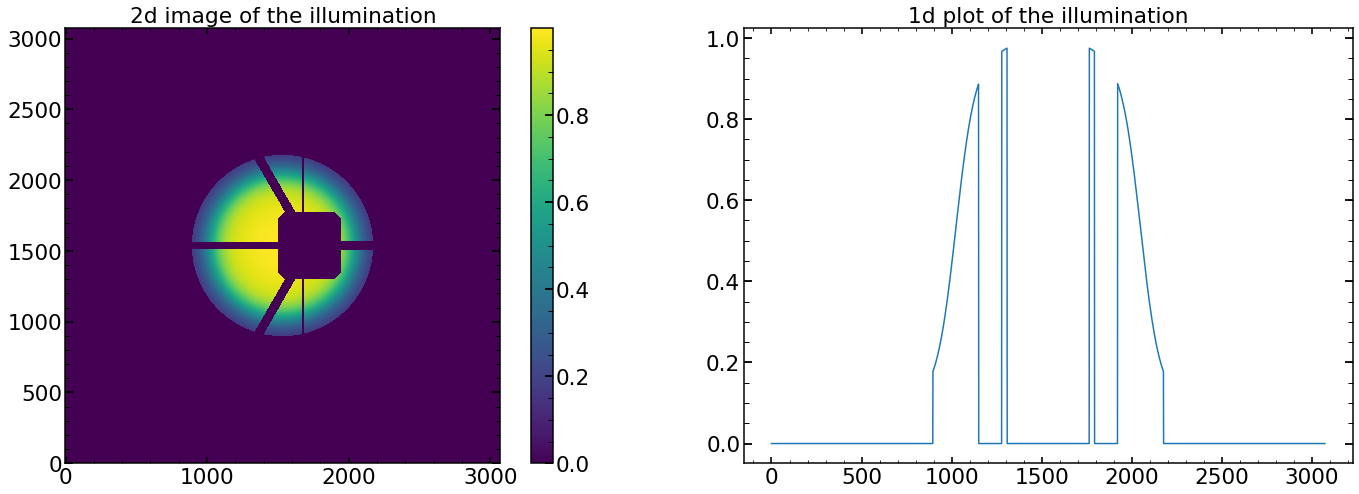

In [51]:
# after we have included the implementation of the FRD and the effective FRD

r=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_resize.npy') 

plt.figure(figsize=(24,8))
plt.subplot(121)
plt.imshow(r,origin='lower')
plt.colorbar()
plt.title('2d image of the illumination')

plt.subplot(122)
plt.plot(r[:,int(r.shape[0]/2+5)])
plt.title('1d plot of the illumination')

## wavefront on the exit pupil

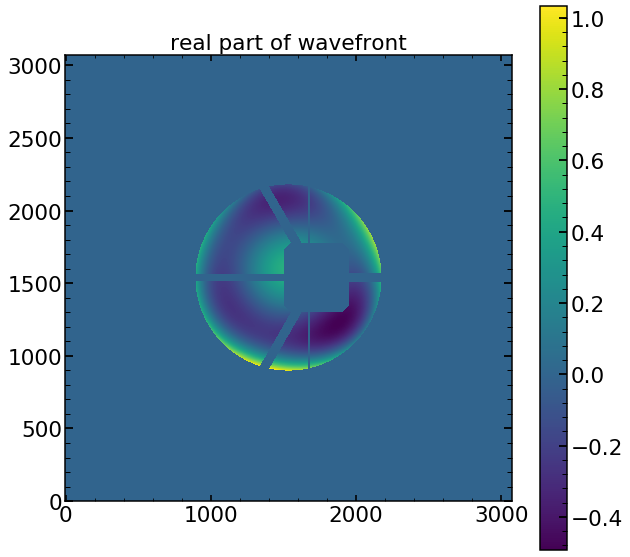

In [9]:
wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')  
plt.figure(figsize=(10,10))
plt.imshow(np.real(wf_grid),origin='lower')
plt.title('real part of wavefront')
plt.colorbar()

(3072, 3072)

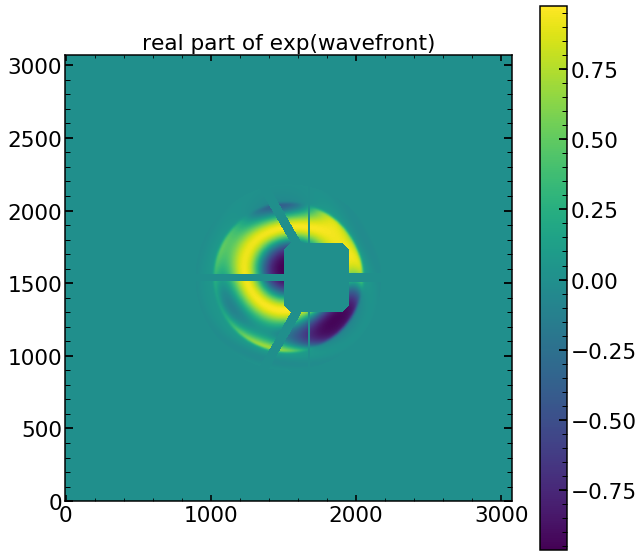

In [10]:
expwf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'expwf_grid.npy')  
plt.figure(figsize=(10,10))
plt.title('real part of exp(wavefront)')
plt.imshow(np.real(expwf_grid),origin='lower')
plt.colorbar()
np.real(expwf_grid).shape

## single spot 

Text(0.5,1,'result of FFT, zoomed in')

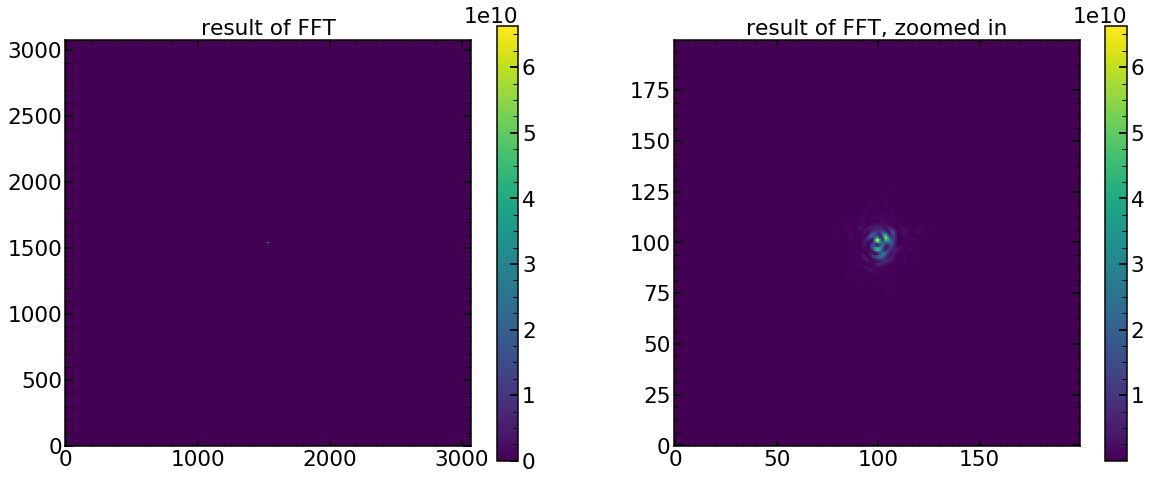

In [11]:
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy') 
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf,origin='lower')
middleposition=int(optPsf.shape[0]/2)
cbar=plt.colorbar()

plt.title('result of FFT')

plt.subplot(122)
plt.imshow(optPsf[middleposition-100:middleposition+100,middleposition-100:middleposition+100],origin='lower')
cbar=plt.colorbar()

plt.title('result of FFT, zoomed in')

Text(0.5,1,'result of FFT, zoomed in, log')

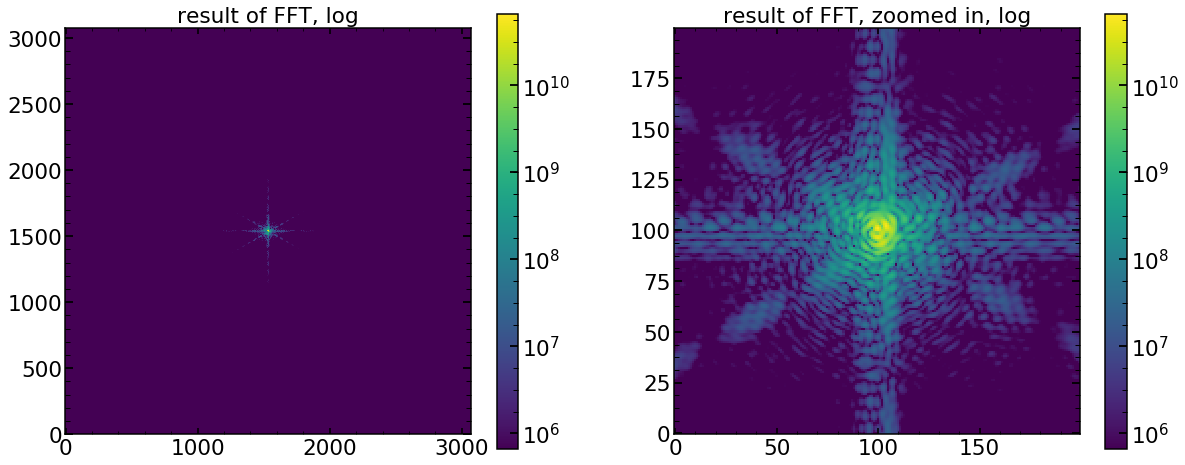

In [12]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf,origin='lower',norm=LogNorm(),vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5)
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('result of FFT, log')

plt.subplot(122)
plt.imshow(optPsf[middleposition-100:middleposition+100,middleposition-100:middleposition+100],origin='lower',norm=LogNorm(),vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5)
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('result of FFT, zoomed in, log')

## spot convolved with fiber 

Text(0.5,1,'fiber convolved spot, zoomed in')

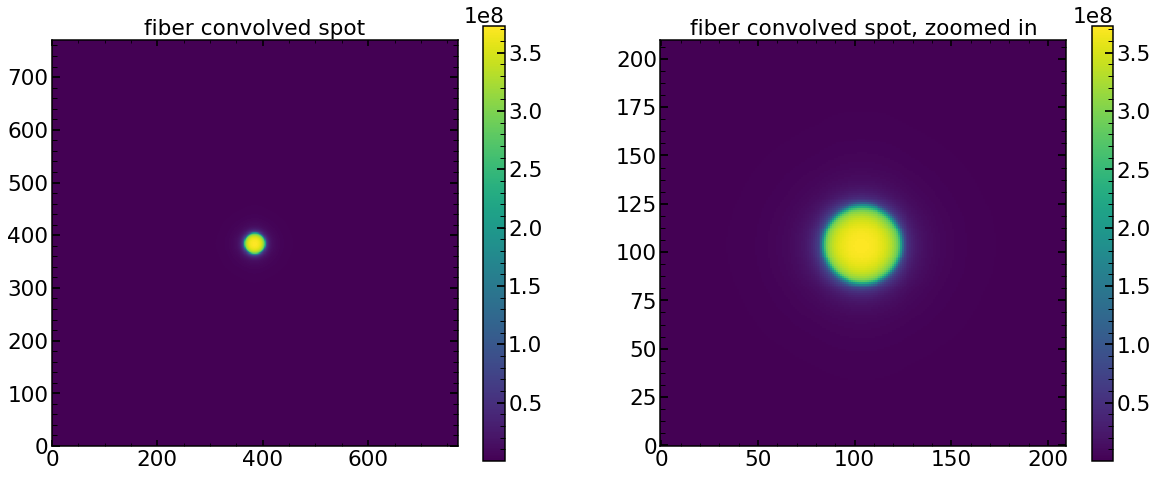

In [15]:
optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')    
middleposition=int(optPsf_cut_fiber_convolved.shape[0]/2)
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf_cut_fiber_convolved,origin='lower')
plt.colorbar()
plt.title('fiber convolved spot')

plt.subplot(122)
plt.imshow(optPsf_cut_fiber_convolved[middleposition-105:middleposition+105,middleposition-105:middleposition+105],origin='lower')
plt.colorbar()
plt.title('fiber convolved spot, zoomed in')

Text(0.5,1,'fiber convolved spot, zoomed in, log')

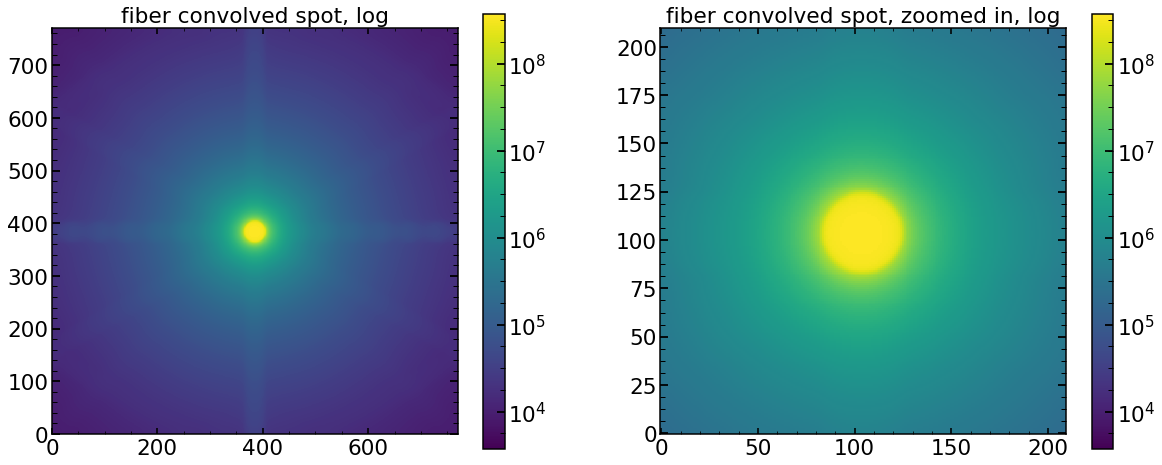

In [16]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf_cut_fiber_convolved,origin='lower',norm=LogNorm(),vmin=np.max(optPsf_cut_fiber_convolved)/10**5)
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('fiber convolved spot, log')

plt.subplot(122)
plt.imshow(optPsf_cut_fiber_convolved[middleposition-105:middleposition+105,middleposition-105:middleposition+105],origin='lower',norm=LogNorm(),vmin=np.max(optPsf_cut_fiber_convolved)/10**5)
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('fiber convolved spot, zoomed in, log')

## spot convolved with fiber and pixel reponse

Text(0.5,1,'fiber and pixel convolved spot, zoomed in')

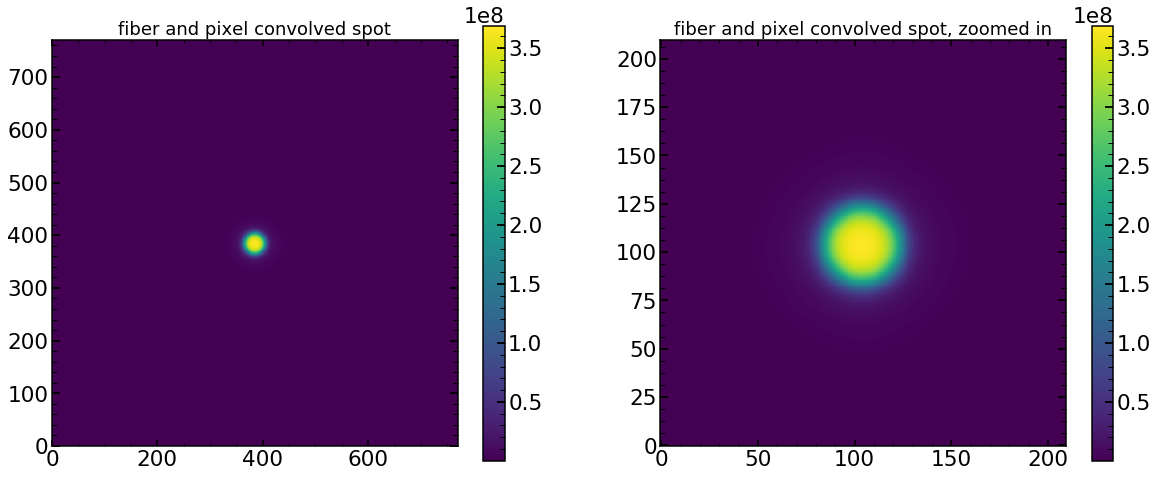

In [17]:
optPsf_cut_pixel_response_convolve=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')   
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf_cut_pixel_response_convolve,origin='lower')
plt.colorbar()
plt.title('fiber and pixel convolved spot', fontsize=18)

plt.subplot(122)
plt.imshow(optPsf_cut_pixel_response_convolve[middleposition-105:middleposition+105,middleposition-105:middleposition+105],origin='lower')
plt.colorbar()
plt.title('fiber and pixel convolved spot, zoomed in', fontsize=18)

Text(0.5,1,'fiber and pixel convolved spot, zoomed in, log')

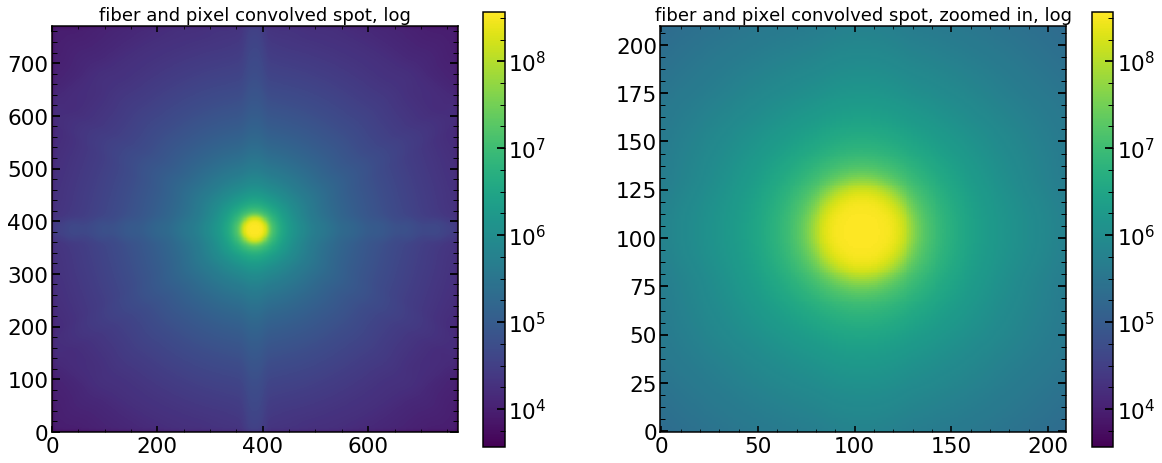

In [18]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf_cut_pixel_response_convolve,origin='lower',norm=LogNorm(),vmin=np.max(optPsf_cut_pixel_response_convolve)/10**5)
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('fiber and pixel convolved spot, log', fontsize=18)

plt.subplot(122)
plt.imshow(optPsf_cut_pixel_response_convolve[middleposition-105:middleposition+105,middleposition-105:middleposition+105],origin='lower',norm=LogNorm(),vmin=np.max(optPsf_cut_pixel_response_convolve)/10**5)
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('fiber and pixel convolved spot, zoomed in, log', fontsize=18)

## final result

Text(0.5,1,'final result, log scale')

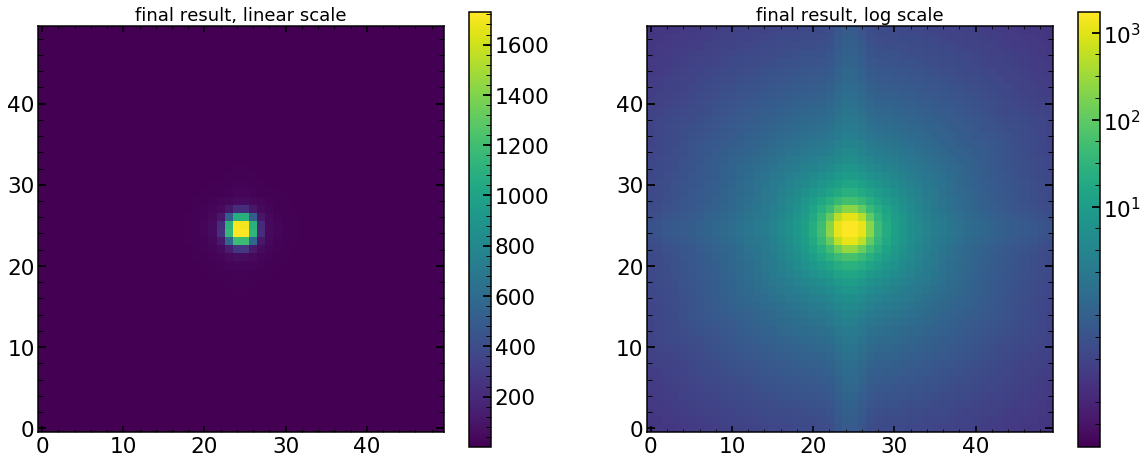

In [19]:
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')   

plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf_cut_fiber_convolved_downsampled,origin='lower')
plt.colorbar()
plt.title('final result, linear scale', fontsize=18)

plt.subplot(122)
plt.imshow(optPsf_cut_fiber_convolved_downsampled,origin='lower',norm=LogNorm(),vmin=np.max(optPsf_cut_fiber_convolved_downsampled)/10**5)
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('final result, log scale', fontsize=18)

Text(0.5,1,'final result  with noise, log scale')

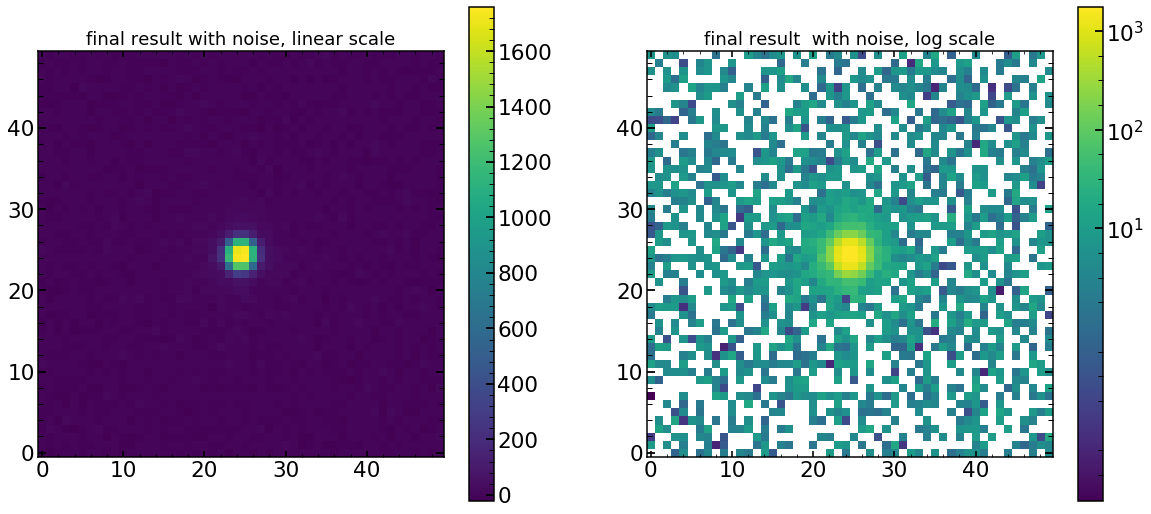

In [20]:
# this part adds noise to the perfect models

# as a very simplified model, assume that the variance images is the same as the science image + some read noise 
var_image=optPsf_cut_fiber_convolved_downsampled+40

artifical_noise_data=np.zeros((var_image.shape[0],var_image.shape[1]))
for i in range(len(artifical_noise_data)):
    for j in range(len(artifical_noise_data)):
        artifical_noise_data[i][j]=np.random.normal(0,np.sqrt(var_image[i][j]))
        

plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(optPsf_cut_fiber_convolved_downsampled+artifical_noise_data,origin='lower')
plt.colorbar()
plt.title('final result with noise, linear scale', fontsize=18)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(222)
plt.imshow(optPsf_cut_fiber_convolved_downsampled+artifical_noise_data,origin='lower',norm=LogNorm(),vmin=np.max(optPsf_cut_fiber_convolved_downsampled)/10**5)
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('final result  with noise, log scale', fontsize=18)        


## final result with arcsinh scaling 

In [23]:
# Create an ImageNormalize object
from astropy.visualization import ( AsinhStretch,
                                   ImageNormalize)

norm = ImageNormalize(optPsf_cut_fiber_convolved_downsampled, vmax=1000,
                      stretch=AsinhStretch())

Text(0.5,1,'final result  with noise, log scale')

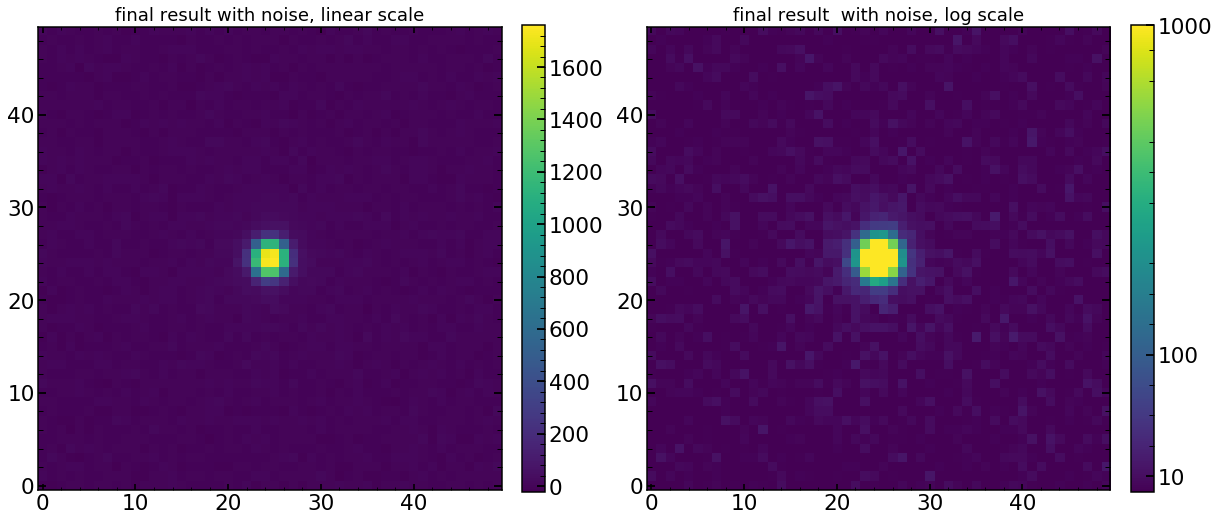

In [26]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(optPsf_cut_fiber_convolved_downsampled+artifical_noise_data,origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('final result with noise, linear scale', fontsize=18)

plt.subplot(122)
plt.imshow(optPsf_cut_fiber_convolved_downsampled+artifical_noise_data,origin='lower',norm=norm,vmin=np.max(optPsf_cut_fiber_convolved_downsampled)/10**5)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('final result  with noise, log scale', fontsize=18)        



# Few Images showing how optical PSF results change when changing parameters

In [44]:
# In the examples below, we have removed all the other abberations so that we can more clearly see the difference when adding specific abberations

## Adding astigmatism (Z5 and Z6)

In [38]:
allparameters_proposal=np.array([0,1,0,0,0,0,0,0,
                                 0.7,0.1,0.3,0.0,0.07,0.0,
                                 0.17,0.67,1,1,
                                 0.0,-0.0,0.80,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])


model(allparameters_proposal)

31


-1150009.1702820328

Text(0.5,1,'result of FFT, zoomed in, log')

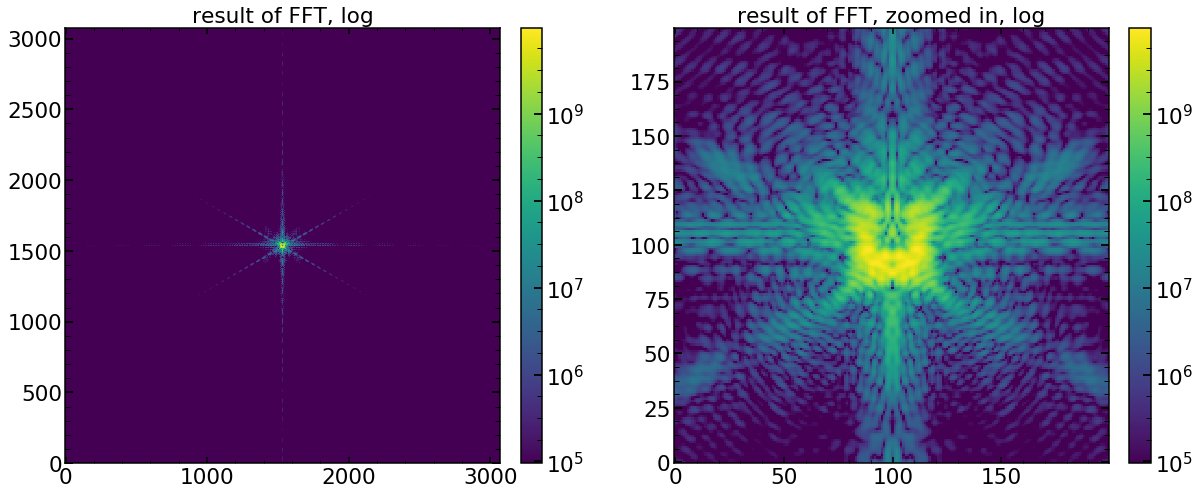

In [39]:
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy') 
middleposition=int(optPsf.shape[0]/2)

plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf,origin='lower',norm=LogNorm(),vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('result of FFT, log')

plt.subplot(122)
plt.imshow(optPsf[middleposition-100:middleposition+100,middleposition-100:middleposition+100],origin='lower',norm=LogNorm(),vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('result of FFT, zoomed in, log')

## Adding coma (Z7 and Z8)

In [40]:
allparameters_proposal=np.array([0,0,0,1,0,0,0,0,
                                 0.7,0.1,0.3,0.0,0.07,0.0,
                                 0.17,0.67,1,1,
                                 0.0,-0.0,0.80,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])


model(allparameters_proposal)

31


-1102622.6961894836

Text(0.5,1,'result of FFT, zoomed in, log')

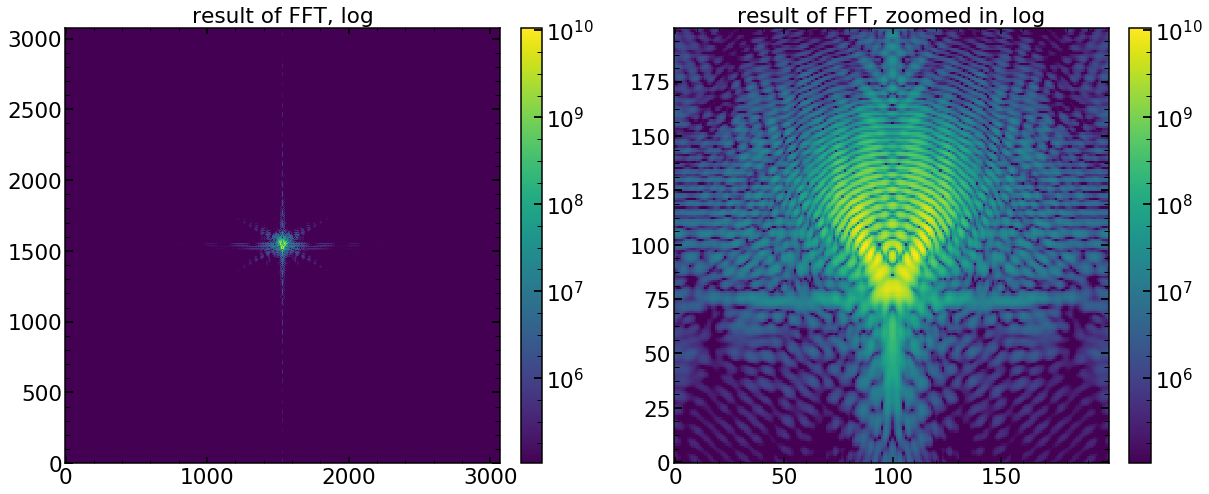

In [41]:
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy') 
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf,origin='lower',norm=LogNorm(),vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('result of FFT, log')

plt.subplot(122)
plt.imshow(optPsf[middleposition-100:middleposition+100,middleposition-100:middleposition+100],origin='lower',norm=LogNorm(),vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('result of FFT, zoomed in, log')

## Adding trefoil (Z9 and Z10)

In [42]:
allparameters_proposal=np.array([0,0,0,0,0,1,1,0,
                                 0.7,0.1,0.3,0.0,0.07,0.0,
                                 0.17,0.67,1,1,
                                 0.0,-0.0,0.80,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])


model(allparameters_proposal)

31


-1088588.358730731

Text(0.5,1,'result of FFT, zoomed in, log')

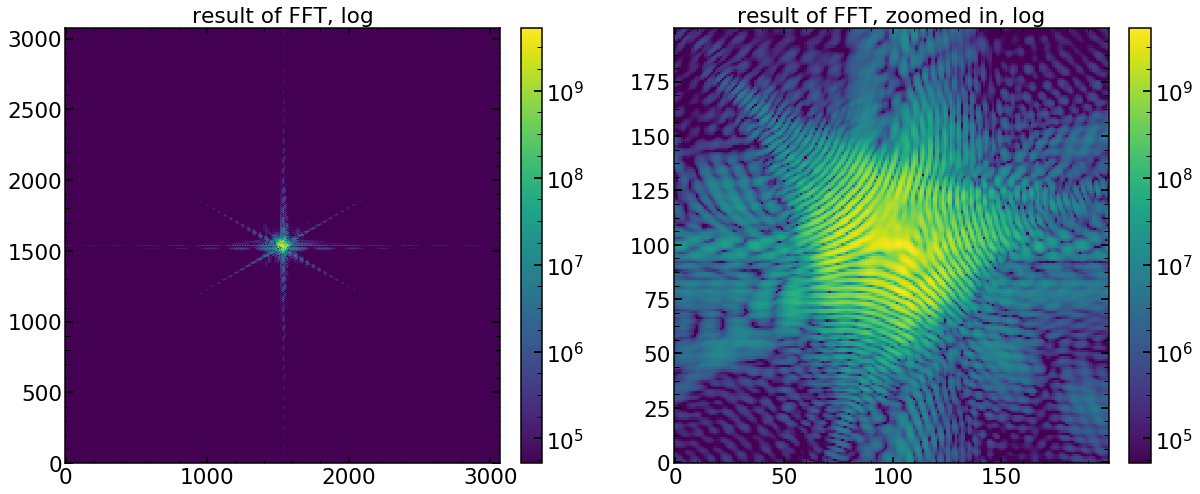

In [43]:
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy') 
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf,origin='lower',norm=LogNorm(),vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('result of FFT, log')

plt.subplot(122)
plt.imshow(optPsf[middleposition-100:middleposition+100,middleposition-100:middleposition+100],origin='lower',norm=LogNorm(),vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('result of FFT, zoomed in, log')